# Transfer learning for check if plant available in image

In [21]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Add, AveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [5]:
custom_input = Input(shape=(256, 256, 3))
base_model = InceptionV3(input_tensor=custom_input,
                         weights='imagenet',
                         include_top=True)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_166 (Conv2D)            (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_165 (Batch  (None, 127, 127, 32  96         ['conv2d_166[0][0]']             
 Normalization)                 )                                                      

In [18]:
test_input = load_img(
    path='../data/image data/test/Orange/Haunglongbing (Citrus greening)/c204b397-cdbf-481f-84d5-72f9e16cfa79___CREC_HLB 7560.JPG',
    target_size=(256, 256))
test_input = img_to_array(test_input)
test_input = test_input.reshape((1, 256, 256, 3))
test_input.shape

(1, 256, 256, 3)

In [20]:
base_model.predict(test_input).max()

0.9942251

In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
train_data = unpickle('../data/Plant/not plant/cifar-100-python/train')
train_data

{b'filenames': [b'bos_taurus_s_000507.png',
  b'stegosaurus_s_000125.png',
  b'mcintosh_s_000643.png',
  b'altar_boy_s_001435.png',
  b'cichlid_s_000031.png',
  b'phone_s_002161.png',
  b'car_train_s_000043.png',
  b'beaker_s_000604.png',
  b'fog_s_000397.png',
  b'rogue_elephant_s_000421.png',
  b'computer_keyboard_s_000757.png',
  b'willow_tree_s_000645.png',
  b'sunflower_s_000549.png',
  b'palace_s_000759.png',
  b'adriatic_s_001782.png',
  b'computer_keyboard_s_001277.png',
  b'bike_s_000682.png',
  b'wolf_pup_s_001323.png',
  b'squirrel_s_002467.png',
  b'sea_s_000678.png',
  b'shrew_s_002233.png',
  b'pine_tree_s_000087.png',
  b'rose_s_000373.png',
  b'surveillance_system_s_000769.png',
  b'pine_s_001533.png',
  b'table_s_000897.png',
  b'opossum_s_001237.png',
  b'quercus_alba_s_000257.png',
  b'leopard_s_000414.png',
  b'possum_s_002195.png',
  b'bike_s_000127.png',
  b'balmoral_castle_s_000361.png',
  b'acer_saccharinum_s_000646.png',
  b'lapin_s_000916.png',
  b'chimp_s_001

In [6]:
train_data[b'data']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [40]:
images = []

for i in range(train_data[b'data'].shape[0]):
    images.append(np.transpose(np.reshape(train_data[b'data'][i], (3, 32, 32)), (1, 2, 0)))

In [42]:
images = np.array(images)
images.shape

(50000, 32, 32, 3)

In [43]:
train_data.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [44]:
for i in range(len(train_data[b'fine_labels'])):
    class_ = f"../data/Plant/not plant/class_{train_data[b'coarse_labels'][i]}"
    if not os.path.isdir(class_):
        os.mkdir(class_)

    dst = os.path.join(f"../data/Plant/not plant/class_{train_data[b'coarse_labels'][i]}",
                       str(train_data[b'filenames'][i].decode("utf-8")))
    image = array_to_img(images[i])
    image.save(dst)

In [32]:
train_data[b'filenames'][0].decode("utf-8")

'bos_taurus_s_000507.png'

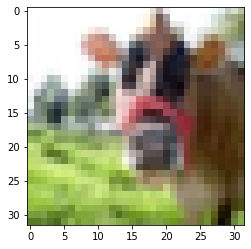

In [41]:
plt.imshow(images[0])

In [3]:
plants = os.listdir('../data/Plant/plant')
not_plant = os.listdir('../data/Plant/not plant')
dst_plant = '../data/Plant/resized_plant'
dst_not_plant = '../data/Plant/resized_not_plant'

for file in plants:
    img_path = os.path.join('../data/Plant/plant', file)
    img = load_img(img_path, target_size=(72, 72))
    img.save(os.path.join(dst_plant, file))

for file in not_plant:
    img_path = os.path.join('../data/Plant/not plant', file)
    img = load_img(img_path, target_size=(72, 72))
    img.save(os.path.join(dst_not_plant, file))

In [10]:
def residual_bottleneck(x, filters):
    # previous layer
    prev_layer = x
    f1, f2, f3 = filters

    # shortcut path
    shortcut = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='same')(prev_layer)
    shortcut = BatchNormalization(axis=3)(shortcut)

    # main path
    prev_layer = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='same')(prev_layer)
    prev_layer = BatchNormalization(axis=3)(prev_layer)
    prev_layer = Activation(relu)(prev_layer)
    prev_layer = Conv2D(filters=f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(prev_layer)
    prev_layer = BatchNormalization(axis=3)(prev_layer)
    prev_layer = Activation(relu)(prev_layer)
    prev_layer = Conv2D(filters=f1, kernel_size=(5, 5), strides=(1, 1), padding='same')(prev_layer)
    prev_layer = BatchNormalization(axis=3)(prev_layer)
    prev_layer = Activation(relu)(prev_layer)

    # combine layer
    addition = Add()([prev_layer, shortcut])
    addition = Activation(relu)(addition)

    return addition

In [16]:
# input layer
input_layer = Input(shape=(72, 72, 3))
x = Conv2D(filters=128, kernel_size=(5, 5), padding='same')(input_layer)
x = Activation(relu)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
x = Activation(relu)(x)

# first residual block
x = residual_bottleneck(x, filters=[128, 128, 64])
x = residual_bottleneck(x, filters=[128, 128, 64])
x = residual_bottleneck(x, filters=[128, 128, 64])

# pooling layer
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

# second residual block
x = residual_bottleneck(x, filters=[256, 256, 96])
x = residual_bottleneck(x, filters=[256, 256, 96])
x = residual_bottleneck(x, filters=[256, 256, 96])

# pooling layer
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# third residual block
x = residual_bottleneck(x, filters=[512, 512, 128])
x = residual_bottleneck(x, filters=[512, 512, 128])
x = residual_bottleneck(x, filters=[512, 512, 128])

x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = AveragePooling2D(pool_size=(3, 3))(x)

# classifier block
x = Dense(units=512, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=1, activation=sigmoid)(x)

model = Model(input_layer, x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv2d_58 (Conv2D)             (None, 72, 72, 128)  9728        ['input_4[0][0]']                
                                                                                                  
 activation_57 (Activation)     (None, 72, 72, 128)  0           ['conv2d_58[0][0]']              
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 36, 36, 128)  0          ['activation_57[0][0]']          
                                                                                            

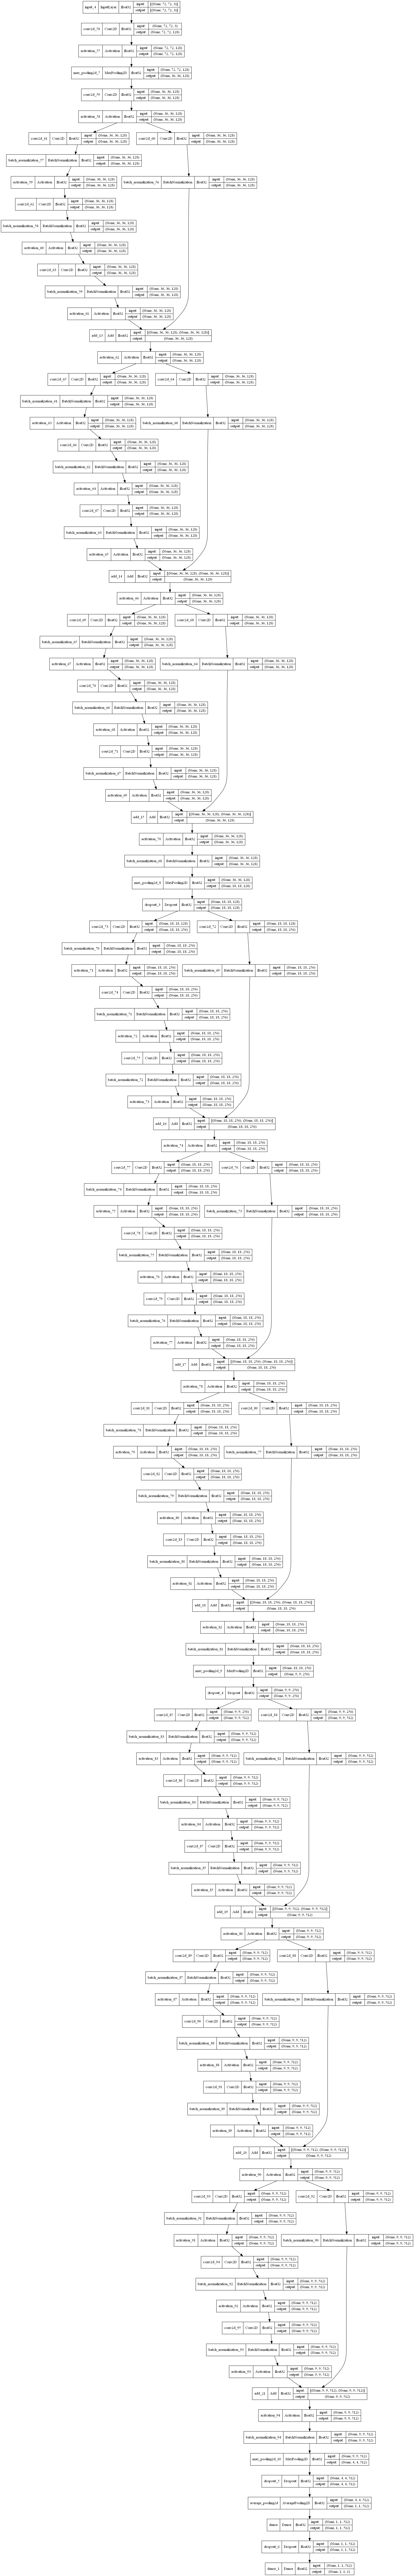

In [17]:
plot_model(model,
           to_file='../models/architecture/custom_resNet.png',
           show_dtype=True,
           show_shapes=True,
           show_layer_names=True)

In [18]:
model.compile(optimizer=Adam(),
              loss=binary_crossentropy,
              metrics=['accuracy'])

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='alexNet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

In [ ]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=45,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)

train_gen = generator.flow_from_directory('',
                                          target_size=(72, 72),
                                          batch_size=376,
                                          subset='training')
validation_gen = generator.flow_from_directory('',
                                               target_size=(72, 72),
                                               batch_size=376,
                                               subset='validation')

In [ ]:
model_history = model.fit(train_gen,
                          epochs=150,
                          callbacks=callbacks,
                          validation_data=validation_gen)

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(model_history.history['loss'])))

sns.lineplot(x=epochs, y=model_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=model_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=model_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=model_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('plant_train_history.png')
plt.show()

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=model_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=model_history.history['lr'], y=model_history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('plant_lr_history.png')
plt.show()